In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/code/func/')
from proj_environment import set_proj_env
from func import get_fdr_p_df

In [3]:
exclude_str = 't1Exclude'
primary_covariate = 'scanageYears'
parc_scale = 200
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, primary_covariate = primary_covariate,
                                                                                       parc_scale = parc_scale)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/analysis/normative/t1Exclude/schaefer_200/scanageYears+sex_adj'

In [5]:
metrics = ('ct', 'vol')
phenos = ('Overall_Psychopathology','Mania','Depression','Psychosis_Positive','Psychosis_NegativeDisorg')

## Load data

In [6]:
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df.shape)

df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df_node.shape)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns); print(df_z.shape)

(1313, 17)
(1313, 400)
(1313, 400)


In [7]:
df.head()

TotalNtimepoints  TotalNtimepoints_new  sex  race  \
bblid scanid timepoint                                                      
80010 2894   1                         2                     2    1     1   
      7211   2                         2                     2    1     1   
80263 6635   1                         3                     3    2     2   
      8454   2                         3                     3    2     2   
      9127   3                         3                     3    2     2   

                        ethnicity  scanageMonths  scanageYears  \
bblid scanid timepoint                                           
80010 2894   1                  2            262          21.8   
      7211   2                  2            293          24.4   
80263 6635   1                  2            278          23.2   
      8454   2                  2            295          24.6   
      9127   3                  2            309          25.8   

                        mprage_antsCT_vol_TBV  averageManualRating  \
bblid scanid timepoint                                               
80010 2894   1                   1.383110e+06                  2.0   
      7211   2                   1.412140e+06                  2.0   
80263 6635   1                   1.110456e+06                  2.0   
      8454   2                   1.111174e+06                  2.0   
      9127   3                   1.090214e+06                  2.0   

                        dti32MeanRelRMS  Overall_Psychopathology     Mania  \
bblid scanid timepoint                                                       
80010 2894   1                 0.669736                 0.477260  0.234406   
      7211   2                 0.173847                -0.313878 -0.511101   
80263 6635   1                 0.290758                 0.366626  1.599553   
      8454   2                 0.774809                      NaN       NaN   
      9127   3                 0.385984                -0.501747 -0.423963   

                        Depression  Psychosis_Positive  \
bblid scanid timepoint                                   
80010 2894   1            0.411101           -0.765745   
      7211   2            2.357006            0.169766   
80263 6635   1            0.063244            1.666237   
      8454   2                 NaN                 NaN   
      9127   3            1.648215           -0.517196   

                        Psychosis_NegativeDisorg  train_test  sex_adj  
bblid scanid timepoint                                                 
80010 2894   1                          1.321310        True        0  
      7211   2                          0.555718        True        0  
80263 6635   1                         -1.151178        True        1  
      8454   2                               NaN        True        1  
      9127   3                          0.535995        True        1

In [8]:
df_z = df_z.abs()

## Plots

In [9]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

In [10]:
df_z_mean = pd.DataFrame(index = df_z.index, columns = metrics)
for metric in metrics:
    df_z_mean[metric] = df_z.filter(regex = metric, axis = 1).mean(axis = 1)

In [11]:
df_z_mean.head()

ct       vol
bblid scanid timepoint                    
80010 2894   1          0.622049  0.649178
      7211   2          0.640423  0.608240
80263 6635   1          0.918499  1.236043
      8454   2          0.909575  1.166406
      9127   3          0.854622  1.305538

Do people change over time?

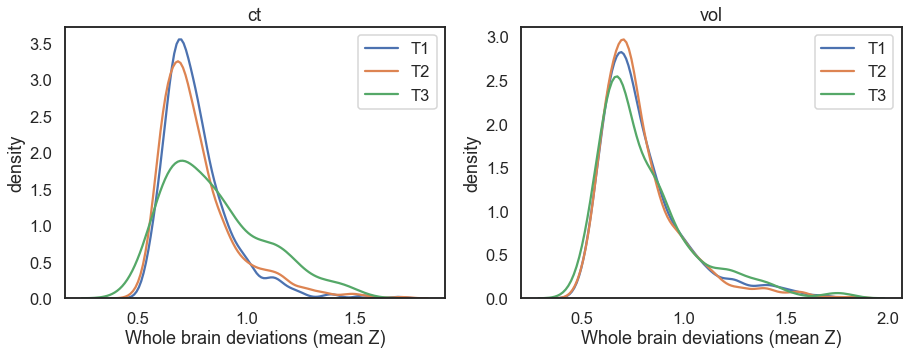

In [12]:
f, axes = plt.subplots(1,2)
f.set_figwidth(15)
f.set_figheight(5)
for i, metric in enumerate(metrics):
    sns.kdeplot(df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(0).loc[:,metric], ax = axes[i], label = 'T1')
    sns.kdeplot(df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(1).loc[:,metric], ax = axes[i], label = 'T2')
    sns.kdeplot(df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(2).loc[:,metric], ax = axes[i], label = 'T3')
    axes[i].set_title(metric)
    axes[i].set_ylabel('density')
    axes[i].set_xlabel('Whole brain deviations (mean Z)')
    axes[i].legend()

In [13]:
def change_score(t1, t2, age_t1, age_t2, raw = False):
    
    diff = t2 - t1 # get raw change score
    interscan = age_t2 - age_t1
    
    if diff.isna().any().any():
        diff.dropna(inplace = True)

    if raw == False:
        for col in t2.columns:
                df_nuis = pd.concat((t1.loc[:,col],interscan), axis = 1) # get T1 score and interscan time as nuisance regs
                df_nuis = sm.add_constant(df_nuis)
                if df_nuis.shape[0] != diff.shape[0]: df_nuis = df_nuis.loc[diff.index,:] # drops to match nan filtered diff

                mdl = sm.OLS(diff.loc[:,col], df_nuis).fit() # predict delta z from T1/interscan time
                y_pred = mdl.predict(df_nuis)
                y_pred.columns = col
                diff.loc[:,col] = diff.loc[:,col] - y_pred # residualize delta against T1
                
    return diff

In [14]:
df_t1 = df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(0)
df_t2 = df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(1)
df_t3 = df_z_mean.groupby(df_z_mean.index.get_level_values(0)).nth(2)

In [15]:
age_t1 = df.groupby(df.index.get_level_values(0)).nth(0).loc[:,primary_covariate]
age_t2 = df.groupby(df.index.get_level_values(0)).nth(1).loc[:,primary_covariate]
age_t3 = df.groupby(df.index.get_level_values(0)).nth(2).loc[:,primary_covariate]

In [16]:
df_t2t1 = change_score(df_t1, df_t2, age_t1, age_t2)
df_t3t2 = change_score(df_t2, df_t3, age_t2, age_t3)

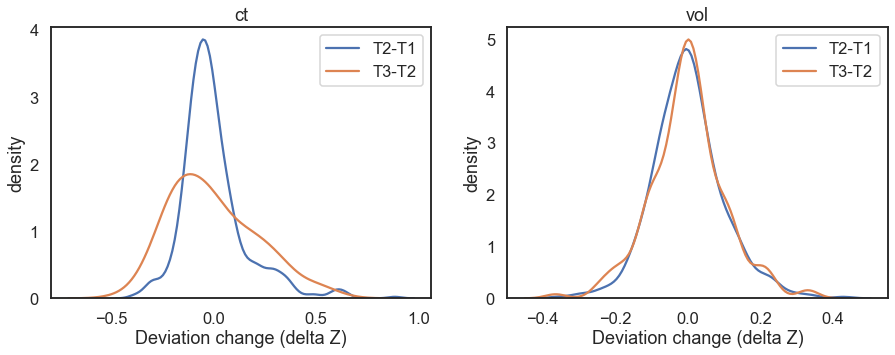

In [17]:
f, axes = plt.subplots(1,2)
f.set_figwidth(15)
f.set_figheight(5)
for i, metric in enumerate(metrics):
    sns.kdeplot(df_t2t1.loc[:,metric], ax = axes[i], label = 'T2-T1')
    sns.kdeplot(df_t3t2.loc[:,metric], ax = axes[i], label = 'T3-T2')
    axes[i].set_title(metric)
    axes[i].set_ylabel('density')
    axes[i].set_xlabel('Deviation change (delta Z)')
    axes[i].legend()

In [18]:
for metric in metrics:
    print(metric, sp.stats.pearsonr(df_t1.loc[:,metric], df_t2t1.loc[:,metric]))

ct (2.301761212186726e-16, 0.9999999999998791)
vol (1.873365828783391e-16, 0.9999999999998791)


In [19]:
for metric in metrics:
    print(metric, sp.stats.pearsonr(df_t2.loc[df_t3t2.index,metric], df_t3t2.loc[:,metric]))

ct (-3.859759734048396e-17, 1.0000000000000355)
vol (-3.135512682828079e-16, 1.0000000000000335)


In [20]:
df_psy_t1 = df.groupby(df.index.get_level_values(0)).nth(0)
df_psy_t2 = df.groupby(df.index.get_level_values(0)).nth(1)
df_psy_t3 = df.groupby(df.index.get_level_values(0)).nth(2)

In [21]:
phenos

('Overall_Psychopathology',
 'Mania',
 'Depression',
 'Psychosis_Positive',
 'Psychosis_NegativeDisorg')

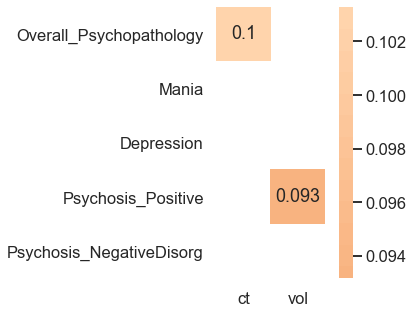

In [22]:
r = pd.DataFrame(index = phenos, columns = metrics)
p = pd.DataFrame(index = phenos, columns = metrics)

for pheno in phenos:
    for metric in metrics:
        idx = df_psy_t2.loc[:,pheno].isna()
        r.loc[pheno,metric] = sp.stats.spearmanr(df_t2t1.loc[~idx,metric], df_psy_t2.loc[~idx,pheno])[0]
        p.loc[pheno,metric] = sp.stats.spearmanr(df_t2t1.loc[~idx,metric], df_psy_t2.loc[~idx,pheno])[1]

# p = get_fdr_p_df(p)
if np.any(p<.05):
    f, ax = plt.subplots(1)
    f.set_figwidth(5)
    f.set_figheight(5)

    sns.heatmap(r[p<.05].astype(float), annot = True, center = 0, ax = ax, square = True)
else:
    print('Nothing sig...')

/Users/lindenmp/opt/anaconda3/envs/neurodev_long/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


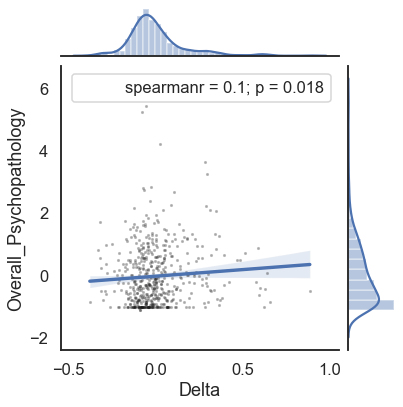

In [23]:
metric = 'ct'
pheno = phenos[0]
idx = df_psy_t2.loc[:,pheno].isna()
f = sns.jointplot(x = df_t2t1.loc[~idx,metric], y = df_psy_t2.loc[~idx,pheno], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Delta');

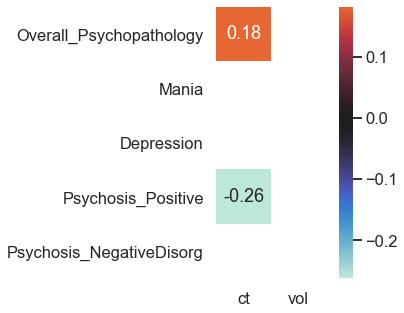

In [24]:
r = pd.DataFrame(index = phenos, columns = metrics)
p = pd.DataFrame(index = phenos, columns = metrics)

for pheno in phenos:
    for metric in metrics:
        idx = df_psy_t3.loc[:,pheno].isna()
        r.loc[pheno,metric] = sp.stats.spearmanr(df_t3t2.loc[~idx,metric], df_psy_t3.loc[~idx,pheno])[0]
        p.loc[pheno,metric] = sp.stats.spearmanr(df_t3t2.loc[~idx,metric], df_psy_t3.loc[~idx,pheno])[1]

# p = get_fdr_p_df(p)
if np.any(p<.05):
    f, ax = plt.subplots(1)
    f.set_figwidth(5)
    f.set_figheight(5)

    sns.heatmap(r[p<.05].astype(float), annot = True, center = 0, ax = ax, square = True)
else:
    print('Nothing sig...')

/Users/lindenmp/opt/anaconda3/envs/neurodev_long/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


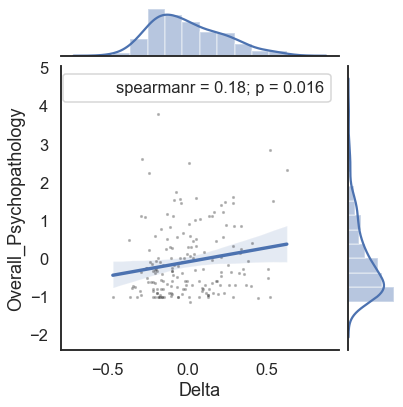

In [25]:
metric = 'ct'
pheno = phenos[0]
idx = df_psy_t3.loc[:,pheno].isna()
f = sns.jointplot(x = df_t3t2.loc[~idx,metric], y = df_psy_t3.loc[~idx,pheno], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Delta');

This is very encouraging!

People whose whole-brain deviations increase over time (abs(T2)-abs(T1), abs(t3)-abs(T2) have higher overall psychopathology at subsequent timepoint

In [26]:
metric = metrics[0]; print(metric)
pheno = phenos[0]; print(pheno)
idx = df_psy_t1.loc[:,pheno].isna()
print(sp.stats.spearmanr(df_t1.loc[~idx,metric], df_psy_t1.loc[~idx,pheno]))
idx = df_psy_t2.loc[:,pheno].isna()
print(sp.stats.spearmanr(df_t2.loc[~idx,metric], df_psy_t2.loc[~idx,pheno]))
idx = df_psy_t3.loc[:,pheno].isna()
print(sp.stats.spearmanr(df_t3.loc[~idx,metric], df_psy_t3.loc[~idx,pheno]))

ct
Overall_Psychopathology
SpearmanrResult(correlation=0.01597500058398163, pvalue=0.7045086742559692)
SpearmanrResult(correlation=0.11750180949560204, pvalue=0.006925967914517401)
SpearmanrResult(correlation=0.2173342509231266, pvalue=0.0039681019788664115)


But, we also get similar stuff between time subjects witin a single time point.. that’s okay, suggest both explain it

The EDA done above just looked at whole-brain averaged deviations. This correlated to overall psychopathology which makes sense and is encouraging. 
Next steps:

1. Clustering of deviations. Need to devise a way to cluster on whole-brain multivariate patterns of longitudinal deviations. If I estimated two params per region, mean z and (adjusted) delta-z, I would have 600 subs * 400 brain features which represent a pair of whole-brain maps for each subject (200 meanz, 200 delta-z)
  * What’s the spatial correlation between mean-z and delta-z maps for each subject?

In [27]:
df_t1 = df_z.groupby(df_z.index.get_level_values(0)).nth(0)
df_t2 = df_z.groupby(df_z.index.get_level_values(0)).nth(1)
df_t3 = df_z.groupby(df_z.index.get_level_values(0)).nth(2)

In [28]:
df_t2t1 = change_score(df_t1, df_t2, age_t1, age_t2, raw = False)
df_t3t2 = change_score(df_t2, df_t3, age_t2, age_t3, raw = False)

(567, 2)
(179, 2)


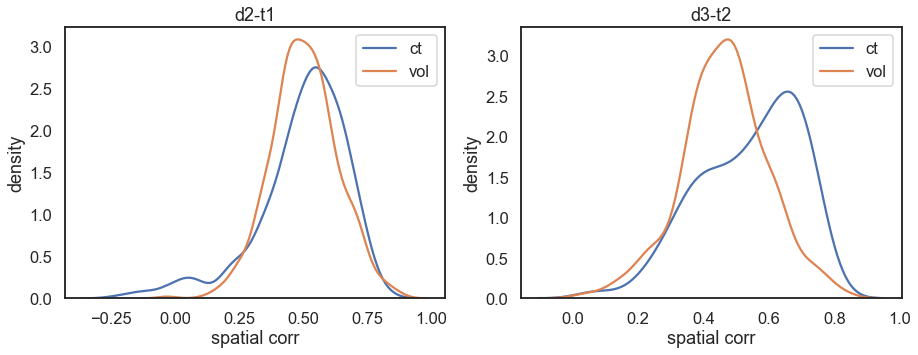

In [29]:
f, axes = plt.subplots(1,2)
f.set_figwidth(15)
f.set_figheight(5)

# temporal_mean = df_z.groupby(df_z.index.get_level_values(0)).mean()
tmp = df_z.groupby(df_z.index.get_level_values(0)).nth([0,1])
temporal_mean = tmp.groupby(tmp.index).mean()

r = np.zeros((df_t2t1.shape[0],len(metrics)))
print(r.shape)

for j, metric in enumerate(metrics):
    for i, (index, data) in enumerate(df_t2t1.filter(regex = metric).iterrows()):
        r[i,j] = sp.stats.pearsonr(data, temporal_mean.filter(regex = metric).loc[index,:])[0]

for j, metric in enumerate(metrics):
    sns.kdeplot(r[:,j], ax = axes[0], label = metric)
axes[0].set_title('d2-t1')
axes[0].set_ylabel('density')
axes[0].set_xlabel('spatial corr')
axes[0].legend()

# temporal_mean = df_z.groupby(df_z.index.get_level_values(0)).mean()
tmp = df_z.groupby(df_z.index.get_level_values(0)).nth([1,2])
temporal_mean = tmp.groupby(tmp.index).mean()

r = np.zeros((df_t3t2.shape[0],len(metrics)))
print(r.shape)

for j, metric in enumerate(metrics):
    for i, (index, data) in enumerate(df_t3t2.filter(regex = metric).iterrows()):
        r[i,j] = sp.stats.pearsonr(data, temporal_mean.filter(regex = metric).loc[index,:])[0]
        
for j, metric in enumerate(metrics):
    sns.kdeplot(r[:,j], ax = axes[1], label = metric)
axes[1].set_title('d3-t2')
axes[1].set_ylabel('density')
axes[1].set_xlabel('spatial corr')
axes[1].legend()

  * Spatial correlations -- they're correlated (r = 0.5), which makes sense, but only when residualized change is extracted.
  * What about regional correlations across subjects?

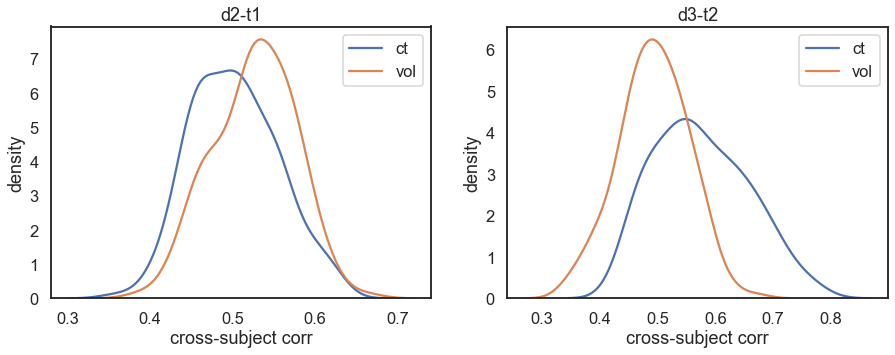

In [30]:
f, axes = plt.subplots(1,2)
f.set_figwidth(15)
f.set_figheight(5)

tmp = df_z.groupby(df_z.index.get_level_values(0)).nth([0,1])
temporal_mean = tmp.groupby(tmp.index).mean()

for j, metric in enumerate(metrics):
    sns.kdeplot(temporal_mean.filter(regex = metric).corrwith(df_t2t1.filter(regex = metric)), ax = axes[0], label = metric)
axes[0].set_title('d2-t1')
axes[0].set_ylabel('density')
axes[0].set_xlabel('cross-subject corr')
axes[0].legend()

tmp = df_z.groupby(df_z.index.get_level_values(0)).nth([1,2])
temporal_mean = tmp.groupby(tmp.index).mean()

for j, metric in enumerate(metrics):
    sns.kdeplot(temporal_mean.filter(regex = metric).corrwith(df_t3t2.filter(regex = metric)), ax = axes[1], label = metric)
axes[1].set_title('d3-t2')
axes[1].set_ylabel('density')
axes[1].set_xlabel('cross-subject corr')
axes[1].legend()

Next steps:
  * Apply k-means clustering to just a single regional z estimate

In [31]:
temporal_mean = df_z.groupby(df_z.index.get_level_values(0)).mean()

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [65]:
metric = 'ct'
# X = temporal_mean.filter(regex = metric)
# X = df_t2t1.filter(regex = metric)
# X = df_t3t2.filter(regex = metric)
X = pd.concat((temporal_mean.filter(regex = metric), df_t2t1.filter(regex = metric)), axis = 1)

sc = StandardScaler()
X_std = sc.fit_transform(X); print(X_std.shape)

(567, 400)


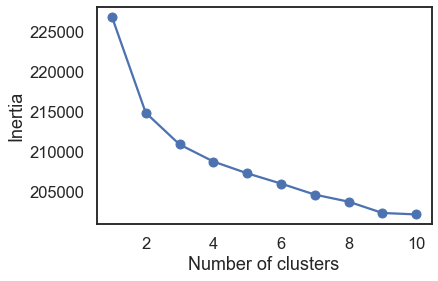

In [66]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X_std)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [58]:
y_km = km.fit_predict(X_std)